In [1]:
# from ..tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image
from pendulum_utils import (
    simulate_double_pendulum,
    save_and_display_animation,
    plot_pendulum_state,
)

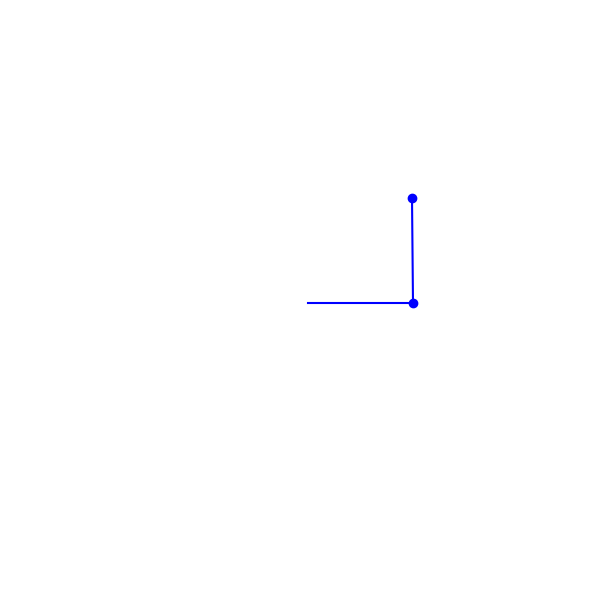

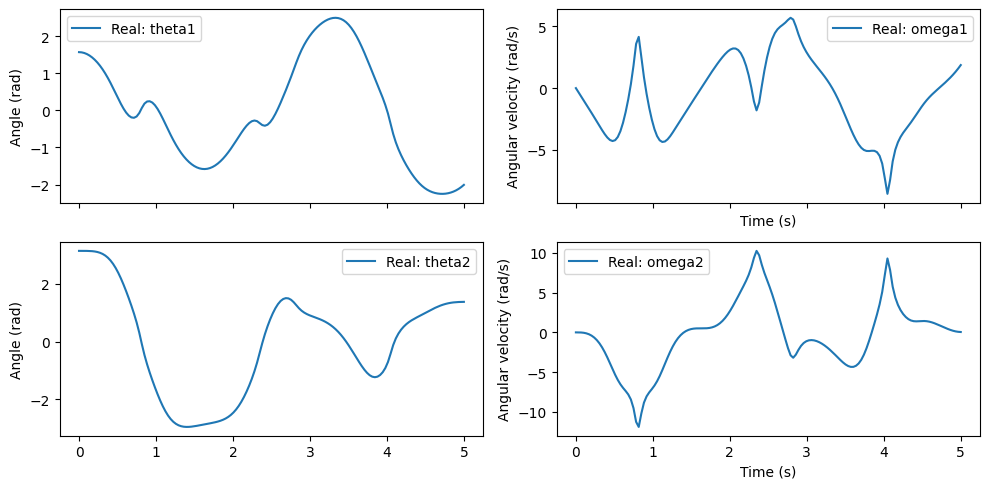

In [2]:
# Parameters and simulation
params = (1.0, 1.0, 1.0, 1.0, 9.81)  # masses, lengths, gravity
initial_state = jnp.array([jnp.pi / 2, 0.0, jnp.pi, 0.0])
fps = 1 / 0.03355705
seconds = 5.0
t = jnp.linspace(0.0, seconds, int(fps * seconds))
trajectory = simulate_double_pendulum(initial_state, t, params)

axs = plot_pendulum_state(trajectory, t, "Real")

save_and_display_animation(trajectory, fps, "real_pendulum")

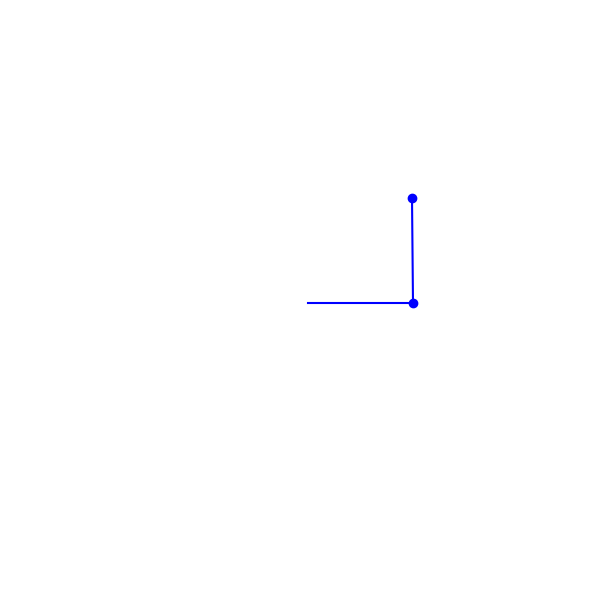

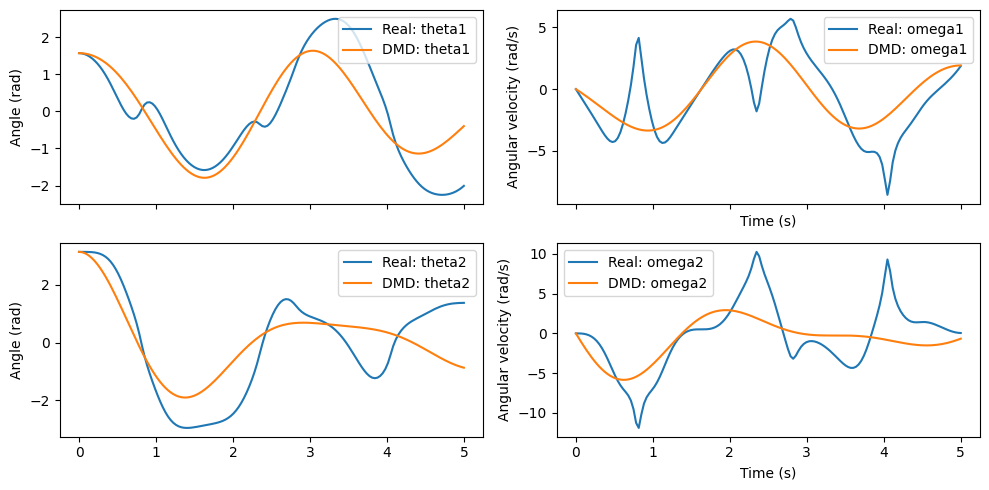

In [3]:
# Construct DMD dataset: X = [x0...x_{n-1}], X' = [x1...x_n]
X1 = trajectory[:-1].T  # shape (4, T-1)
X2 = trajectory[1:].T  # shape (4, T-1)

# Perform SVD on X1
U, S, Vh = np.linalg.svd(X1, full_matrices=False)

# Truncate rank (optional)
r = 4  # full rank
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh[:r, :]

# Compute Koopman (DMD) matrix
A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sr)
A_dmd = X2 @ Vr.T @ np.linalg.inv(Sr) @ Ur.T

# Predict forward from x_0 using DMD
x_pred = [X1[:, 0]]
for _ in range(len(X1.T)):
    x_pred.append(A_dmd @ x_pred[-1])
x_pred = np.stack(x_pred, axis=1).T  # shape (T-1, 4)

axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(x_pred, t, "DMD", axs)

save_and_display_animation(x_pred, fps, "DMD_pendulum")

In [14]:
import sys

sys.path.append("..")  # or the full path to your project root if needed

from train_tools import train_koopman_model

with jax.debug_nans(True):
    model, koopman_op = train_koopman_model(
        trajec=trajectory, latent_dim=8, lr=1e-3, steps=10000, matvecs=8, seed=1
    )

Step 0 | Loss: 73.22486
Step 100 | Loss: 3.12395
Step 200 | Loss: 0.83165
Step 300 | Loss: 0.43931
Step 400 | Loss: 0.23992
Step 500 | Loss: 0.15324
Step 600 | Loss: 0.11411
Step 700 | Loss: 0.09148
Step 800 | Loss: 0.07763
Step 900 | Loss: 0.06739
Step 1000 | Loss: 0.06088
Step 1100 | Loss: 0.05527
Step 1200 | Loss: 0.05088
Step 1300 | Loss: 0.04704
Step 1400 | Loss: 0.11377
Step 1500 | Loss: 0.05737
Step 1600 | Loss: 0.04938
Step 1700 | Loss: 0.04488
Step 1800 | Loss: 0.04176
Step 1900 | Loss: 0.03985
Step 2000 | Loss: 0.03818
Step 2100 | Loss: 0.03661
Step 2200 | Loss: 0.03535
Step 2300 | Loss: 0.03425
Step 2400 | Loss: 0.03327
Step 2500 | Loss: 0.03218
Step 2600 | Loss: 0.03130
Step 2700 | Loss: 0.03040
Step 2800 | Loss: 0.02970
Step 2900 | Loss: 0.02900
Step 3000 | Loss: 0.02831
Step 3100 | Loss: 0.02779
Step 3200 | Loss: 0.02719
Step 3300 | Loss: 0.02656
Step 3400 | Loss: 0.02609
Step 3500 | Loss: 0.02556
Step 3600 | Loss: 0.02503
Step 3700 | Loss: 0.02471
Step 3800 | Loss: 0.024

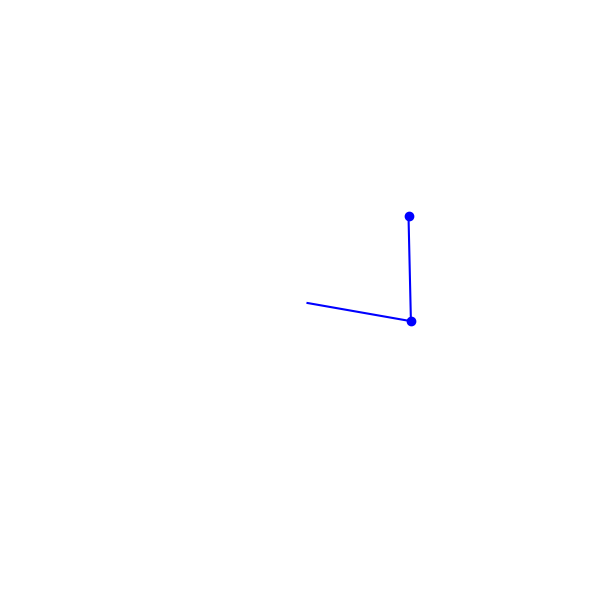

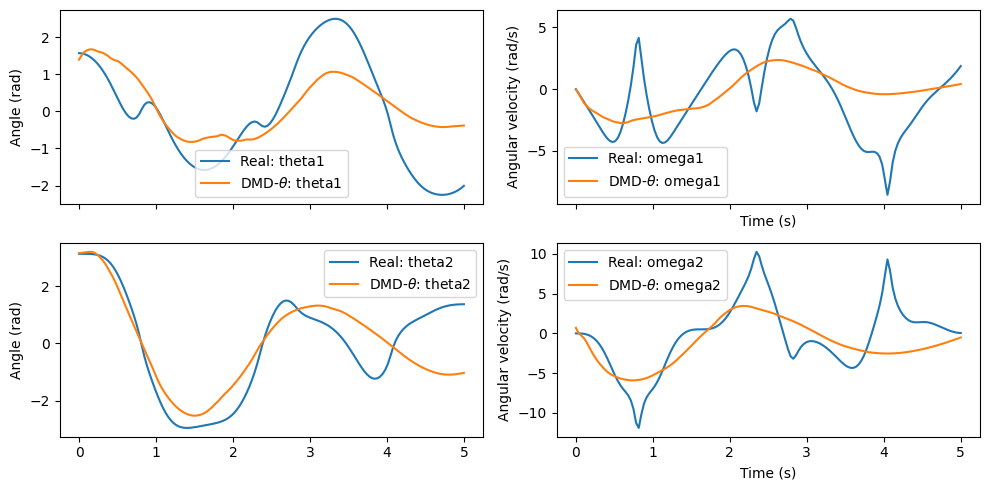

In [5]:
# phi_next_hat = (A_koop @ phi_t.T).T  # (T-1, k)
# x_next_hat = jax.vmap(model.decode)(phi_next_hat)

all_encoded = jax.vmap(lambda x: model.encode(x))(trajectory)
latent_seq = [model.encode(trajectory[0, :])]
for g in range(len(trajectory) - 1):
    if True:  # g % 5 <= 3:
        latent_seq.append(koopman_op @ latent_seq[-1].T)
    else:
        latent_seq.append(all_encoded[g + 1].T)
latent_seq = np.stack(latent_seq, axis=1).T  # shape (T-1, 4)
decoded = jax.vmap(lambda x: model.decode(x))(latent_seq)

# save_and_display_animation(decoded, 1.0, "trained_DMD_pendul")
axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(decoded, t[: len(decoded)], r"DMD-$\theta$", axs)
# make gif:
save_and_display_animation(decoded, fps, "latent_DMD_pendulum", override_existing=True)
